# **뉴스 기사 요약**

- [뉴스 기사 데이터](https://github.com/sunnysai12345/News_Summary)

### 목차

1. [데이터 로드](#데이터-로드)
2. [데이터 전처리](#데이터-전처리)
3. [Encoder&Decoder 생성](#Encoder&Decoder-생성)
4. [Train, test dataset split](#Train,-test-dataset-split)
5. [패딩 추가](#패딩-추가)
6. [모델 설계: seq2seq + Attention](#모델-설계:-seq2seq-+-Attention)
7. [모델 학습](#모델-학습)
8. [모델 검증, 성능 확인](#모델-검증,-성능-확인)

## 이론 정리

텍스트 요약이란 긴 길이의 문서 원문을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 것을 말한다.

- 핵심은 요약 전후 정보 소실을 최소화하는 것!
- 방법 1: 추출 요약 Extractive Summarization
- 방법 2: 추상 요약 Abstractive Summarization

### 추출 요약

- 예를 들어 10개의 전체 문장에서 핵심적인 3개 문장을 꺼내오는 방식
- 문장 분류라고도 볼 수 있다. Text Classification
- 그러나 문장 연결이 자연스럽지 않을 수도 있다.
- TextRank 같은 머신러닝 알고리즘을 이용한다.
- 예: 네이버 뉴스 요약봇

### 추상 요약

- 원문 내용을 요약한 새로운 문장을 생성한다.
- 자연어 생성 Natural Language Generation, NLG 영역
- RNN을 이용할 수도 있지만, 단점은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 것.
- 즉 이러한 장기 의존성(Long term dependencies) 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 이마저도 부족해서 어텐션 메커니즘이 등장했다.

### seq2seq(sequence-to-sequence)

- 요약문을 생성하는 모델을 딥러닝을 통해 end-to-end로 설계하도록 한다.
- 구글이 메일 서비스에 적용한 자동 회식 기능과 비슷한 기법
- 인코더와 디코더의 구조로 구성된 딥러닝 아키텍처

### seq2seq 모델로 Abstractive 요약 방식의 텍스트 요약기

- seq2seq은 RNN 아키텍처 2개를 사용해서 입력 시퀀스로부터 출력 시퀀스를 생성해낸다.
- 주로 뉴럴 기계번역에 사용되는 모델
- 원문을 첫 번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환하고, 이 벡터를 문맥 정보를 가지고 있는 벡터로 하여 컨텐스트 벡터라고 한다.
- 두 번째 RNN인 디코더는 이 컨텍스트 벡터를 전달 받아 한 단어씩 생성해내서 요약 문장을 완성한다.

![image](https://user-images.githubusercontent.com/80008411/139969595-32c24db0-6396-4988-848a-2aa8e66b3e83.png)


### LSTM과 바닐라 RNN의 차이

- 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점
- 다시 말해, 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두개의 값 모두 존재해야 한다.


![image](https://user-images.githubusercontent.com/80008411/139969626-08714992-7303-4775-8e6a-43ad6f08211f.png)


# **구현**

In [1]:
# basic libraries
import os
import re
import time
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
import requests
import warnings
warnings.filterwarnings(action='ignore')

from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

# for prepreocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for modeling & training
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from attention import AttentionLayer
from summa.summarizer import summarize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 로드

In [2]:
# 데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
84256,Veteran actor Amrit Pal passes away aged 76,Veteran actor Amrit Pal passed away aged 76 on...
5730,PMO takes note of 'land mafia' threats to Dili...,The Prime Minister's Office (PMO) has taken no...
74145,Saudi man divorces wife for walking ahead: Rep...,A Saudi man has divorced his wife for walking ...
17119,Vodafone & Idea come together to create IndiaÃ...,Vodafone India and Idea Cellular have come tog...
15872,Better to be unique than best: SC Judge on Aad...,Reading out his verdict on Aadhaar's constitut...
25889,Man City to get Ã¢ÂÂ¹35 crore due to its play...,English Premier League champions Manchester Ci...
3739,"11-year-old girl's body found, minor uncle acc...",The body of an 11-year-old girl was found in t...
60781,Hyperloop-inspired startup to build test track...,Hyperloop-inspired transportation startup Arri...
47617,Illegal registration of properties way of life...,Illegal registration of commercial properties ...
452,Ambedkar was given Bharat Ratna out of compuls...,"AIMIM chief Asaduddin Owaisi on Sunday said, ""..."


## 데이터 전처리

- 1) 중복값, 결측치 처리
- 2) 텍스트 정규화
    - 불용어 제거는 하지 않는다.
- 3) 소문자 변환, 특수 문자 제거
- 4) 문장 최대 길이 설정

In [4]:
data.describe()

,headlines,text
count,98401,98401
unique,98280,98360
top,Don Bradman once scored 100 runs in 3 overs,Safeguard yourself against life's unpleasant s...
freq,3,2


In [5]:
# text 중복 제거
data.drop_duplicates(subset=['text'], inplace=True)

data.describe()

,headlines,text
count,98360,98360
unique,98262,98360
top,Don Bradman once scored 100 runs in 3 overs,"Lt General (Retd) DS Hooda, who oversaw the 20..."
freq,3,1


In [6]:
# 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 텍스트 정규화

In [7]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 불용어 리스트
# 사용하지 않음
# print('불용어 개수 :', len(stopwords.words('english') ))
# print(stopwords.words('english'))

### 소문자 변환, 특수문자 제거

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=False):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub("'",'', sentence) # 따옴표 ' 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 시
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 시(default)
    else:
        tokens = ' '.join(word for word in sentence.split())
    return tokens

In [10]:
# 전처리 함수 test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

# 불용어를 제거하지 않습니다.
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary))  

everything i bought was great infact i ordered twice and the third ordered was br for my mother and father
great way to start the day


In [11]:
start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords=False):
    texts = []
    for s in sentences:
        texts.append(preprocess_sentence(s))
    return texts


def preprocess_data(data, remove_stopwords=False):
    start_time = time.time()
    
    # 컴퓨터의 코어 수를 구합니다
    num_cores = mp.cpu_count()  

    # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    text_data_split = np.array_split(data, num_cores) 
    pool = Pool(num_cores)

    # 각자 작업한 데이터를 하나로 합쳐줍니다
    processed_data = np.concatenate(pool.map(partial(appendTexts), text_data_split))
    pool.close()
    pool.join()
    
    print(time.time() - start_time, " seconds")
    return processed_data

In [12]:
clean_text = preprocess_data(data['text'])
print(clean_text)

clean_summary = preprocess_data(data['headlines'])
print(clean_summary)

1.7487173080444336  seconds
['saurav kant an alumnus of upgrad and iiit bs pg program in machine learning and artificial intelligence was a sr systems engineer at infosys with almost years of work experience the program and upgrads degree career support helped him transition to a data scientist at tech mahindra with salary hike upgrads online power learning has powered lakh careers'
 'kunal shahs credit card bill payment platform cred gave users a chance to win free food from swiggy for one year pranav kaushik a delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more'
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharmas captaincy after consecutive victories dating back to march the match witnessed india getti

In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit bs p...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...
2,new zealand end rohit sharma led indias match ...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...


In [14]:
data.describe()

,headlines,text
count,98360,98360
unique,98170,98330
top,worlds richest people lose billion in one day,real madrid defeated barcelona in an el clasic...
freq,4,2


### 한번 더 중복 & 결측치 처리

In [15]:
data.drop_duplicates(subset=['text'], inplace=True)

data.describe()

,headlines,text
count,98330,98330
unique,98153,98330
top,worlds richest people lose billion in one day,nasas juno space probe which is currently orbi...
freq,4,1


In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 문장 최대 길이 설정

In [17]:
# 길이의 분포 시각화해보기
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 57.731831587511444
요약의 최소 길이 : 1
요약의 최대 길이 : 17
요약의 평균 길이 : 9.422495677819587


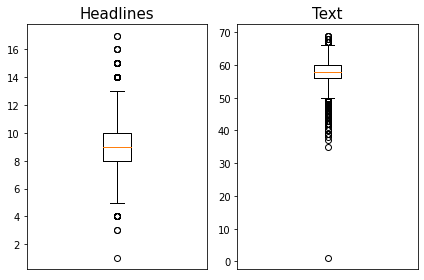

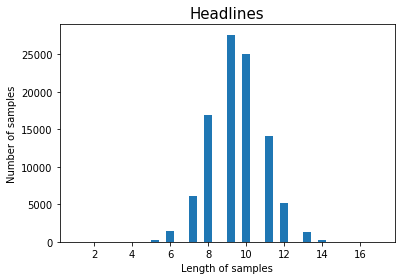

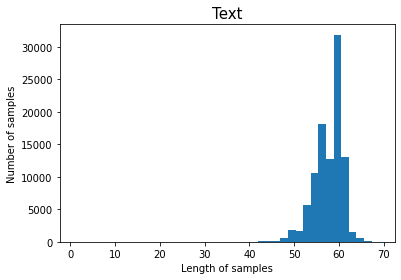

In [18]:
plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.xticks([])
plt.title('Headlines', fontsize=15)
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.xticks([])
plt.title('Text', fontsize=15)
plt.tight_layout()
plt.show()

plt.title('Headlines', fontsize=15)
plt.hist(summary_len, bins = 40)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.show()

plt.title('Text', fontsize=15)
plt.hist(text_len, bins = 40)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.show()

In [19]:
# 모든 데이터를 포함하는 최대값을 설정
text_max_len = 70
summary_max_len = 18

In [20]:
# text_len이 가장 작은 data의 index 확인해보기
np.argmin(text_len)

52

In [21]:
data.loc[data.index == 52]

,headlines,text
52,headlines,text


의미 없는 데이터이므로 삭제

In [22]:
data.drop(axis=0, index=52, inplace=True)

data.describe()

,headlines,text
count,98329,98329
unique,98152,98329
top,amazon invests crore in indian payments arm am...,nasas juno space probe which is currently orbi...
freq,4,1


한번 더 길이 분포 확인해보기

In [23]:
# 길이의 분포 시각화해보기
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 35
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 57.73240854681732
요약의 최소 길이 : 3
요약의 최대 길이 : 17
요약의 평균 길이 : 9.422581334092689


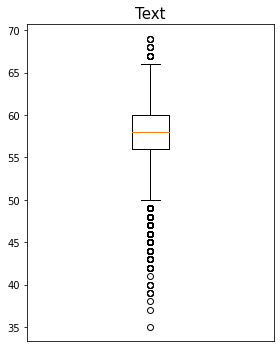

In [24]:
plt.figure(figsize=(4, 5))
plt.boxplot(text_len)
plt.xticks([])
plt.title('Text', fontsize=15)
plt.tight_layout()
plt.show()

## Encoder & Decoder 생성

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit bs p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led indias match ...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led indias match ...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [26]:
data.describe()

,headlines,text,decoder_input,decoder_target
count,98329,98329,98329,98329
unique,98152,98329,98152,98152
top,amazon invests crore in indian payments arm am...,nasas juno space probe which is currently orbi...,sostoken worlds richest people lose billion in...,amazon invests crore in indian payments arm am...
freq,4,1,4,4


In [27]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## Train, test dataset split

In [28]:
encoder_input_train, encoder_input_test = train_test_split(encoder_input, test_size=0.2, random_state=53)

print('encoder_input_train: ', len(encoder_input_train))
print('encoder_input_test: ', len(encoder_input_test))

encoder_input_train:  78663
encoder_input_test:  19666


In [29]:
decoder_input_train, decoder_input_test = train_test_split(decoder_input, test_size=0.2, random_state=53)

print('decoder_input_train: ', len(decoder_input_train))
print('decoder_input_test: ', len(decoder_input_test))

decoder_input_train:  78663
decoder_input_test:  19666


In [30]:
decoder_target_train, decoder_target_test = train_test_split(decoder_target, test_size=0.2, random_state=53)

print('decoder_target_train: ', len(decoder_target_train))
print('decoder_target_test: ', len(decoder_target_test))

decoder_target_train:  78663
decoder_target_test:  19666


### Word Dictionary 만들기

In [31]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [32]:
word_count_dict = src_tokenizer.word_counts

### Word Count 분포 및 빈도 확인

In [33]:
counts = [cnt for word, cnt in word_count_dict.items()]
words = [word for word, cnt in word_count_dict.items()]

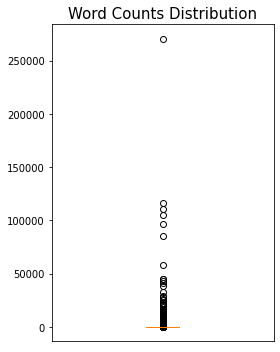

In [34]:
plt.figure(figsize=(4, 5))
plt.boxplot(counts)
plt.xticks([])
plt.title('Word Counts Distribution', fontsize=15)
plt.tight_layout()
plt.show()

In [35]:
for i, c in enumerate(counts):
    if c > 200000:
        print('index:', i, 'count:', c)

index: 18 count: 270425


In [36]:
words[18]

'the'

In [37]:
# 빈도수가 10회 미만인 단어들이 얼마나 되는지 확인
threshold = 10
total_cnt = len(src_tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0


for k, v in src_tokenizer.word_counts.items():
    total_freq += v
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if v < threshold:
        rare_cnt += 1
        rare_freq += v
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 73895
등장 빈도가 9번 이하인 희귀 단어의 수: 54887
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19008
단어 집합에서 희귀 단어의 비율: 74.27701468299614
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.937338610943975


In [38]:
src_vocab = 19008

src_tokenizer = Tokenizer(num_words=src_vocab, oov_token="<OOV>") 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4, 127, 6, 4, 4505, 1557, 9, 807, 915, 8, 243, 188, 200, 55, 16547, 2660, 14270, 62, 19, 2, 105, 8, 55, 615, 819, 29, 36, 11911, 3, 95, 57, 2488, 2, 14270, 19, 62, 6, 2, 156, 11, 554, 2, 1890, 78, 41, 3129, 380, 4437, 33, 963, 13, 246, 3500, 33, 2954, 23, 62, 6, 2, 16547], [704, 201, 7, 341, 6, 5174, 185, 1737, 1798, 2865, 2462, 9, 11, 12, 82, 27, 3, 385, 3, 390, 3, 1591, 794, 82, 1292, 6, 27, 3, 11912, 5, 337, 3, 2385, 12, 999, 15, 31, 2462, 42, 4718, 52, 390, 6810, 7, 5267, 12, 5, 337, 3, 27, 1328, 5, 390, 2, 682, 6, 4154, 766, 26, 6977], [316, 5, 1160, 27, 700, 4, 9323, 2110, 123, 1, 1825, 12, 81, 1477, 72, 1109, 7437, 16548, 5, 2, 127, 2, 4999, 2110, 14, 246, 240, 1, 3, 16549, 4, 4105, 6, 1, 17, 30, 11617, 1470, 7, 10375, 22, 94, 2, 1635, 2, 2110, 14, 983, 10, 4467, 6, 2925, 10, 6888, 5037, 217, 21, 2809, 784, 7, 5709]]


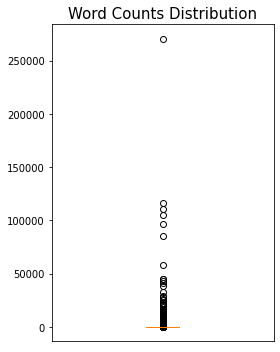

In [40]:
word_count_dict = src_tokenizer.word_counts

counts = [cnt for word, cnt in word_count_dict.items()]
words = [word for word, cnt in word_count_dict.items()]

plt.figure(figsize=(4, 5))
plt.boxplot(counts)
plt.xticks([])
plt.title('Word Counts Distribution', fontsize=15)
plt.tight_layout()
plt.show()

### headline 데이터에 동일한 작업 수행

In [41]:
# summary data에 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [42]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31895
등장 빈도가 3번 이하인 희귀 단어의 수: 18253
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13642
단어 집합에서 희귀 단어의 비율: 57.22840570622355
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3454728178809


In [43]:
tar_vocab = 13642
tar_tokenizer = Tokenizer(num_words=tar_vocab, oov_token="<OOV>") 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[2, 11938, 2308, 9051, 8, 8450, 519, 764, 12, 3030, 1429], [2, 148, 54, 4, 281, 4, 323, 4, 809, 589, 2262, 1396], [2, 7407, 968, 92, 82, 3476, 1679, 11939, 104], [2, 377, 93, 104, 6, 19, 4111, 23, 4112, 720, 449], [2, 292, 10752, 31, 14, 107, 13, 1050, 375]]
decoder  [[11938, 2308, 9051, 8, 8450, 519, 764, 12, 3030, 1429, 3], [148, 54, 4, 281, 4, 323, 4, 809, 589, 2262, 1396, 3], [7407, 968, 92, 82, 3476, 1679, 11939, 104, 3], [377, 93, 104, 6, 19, 4111, 23, 4112, 720, 449, 3], [292, 10752, 31, 14, 107, 13, 1050, 375, 3]]


In [44]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78663
훈련 레이블의 개수 : 78663
테스트 데이터의 개수 : 19666
테스트 레이블의 개수 : 19666


## 패딩 추가

In [45]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

<hr>

<br>

## 모델 설계: seq2seq + Attention

In [46]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256     # hidden state의 크기

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [47]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [48]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [49]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 128)      2433024     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 70, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

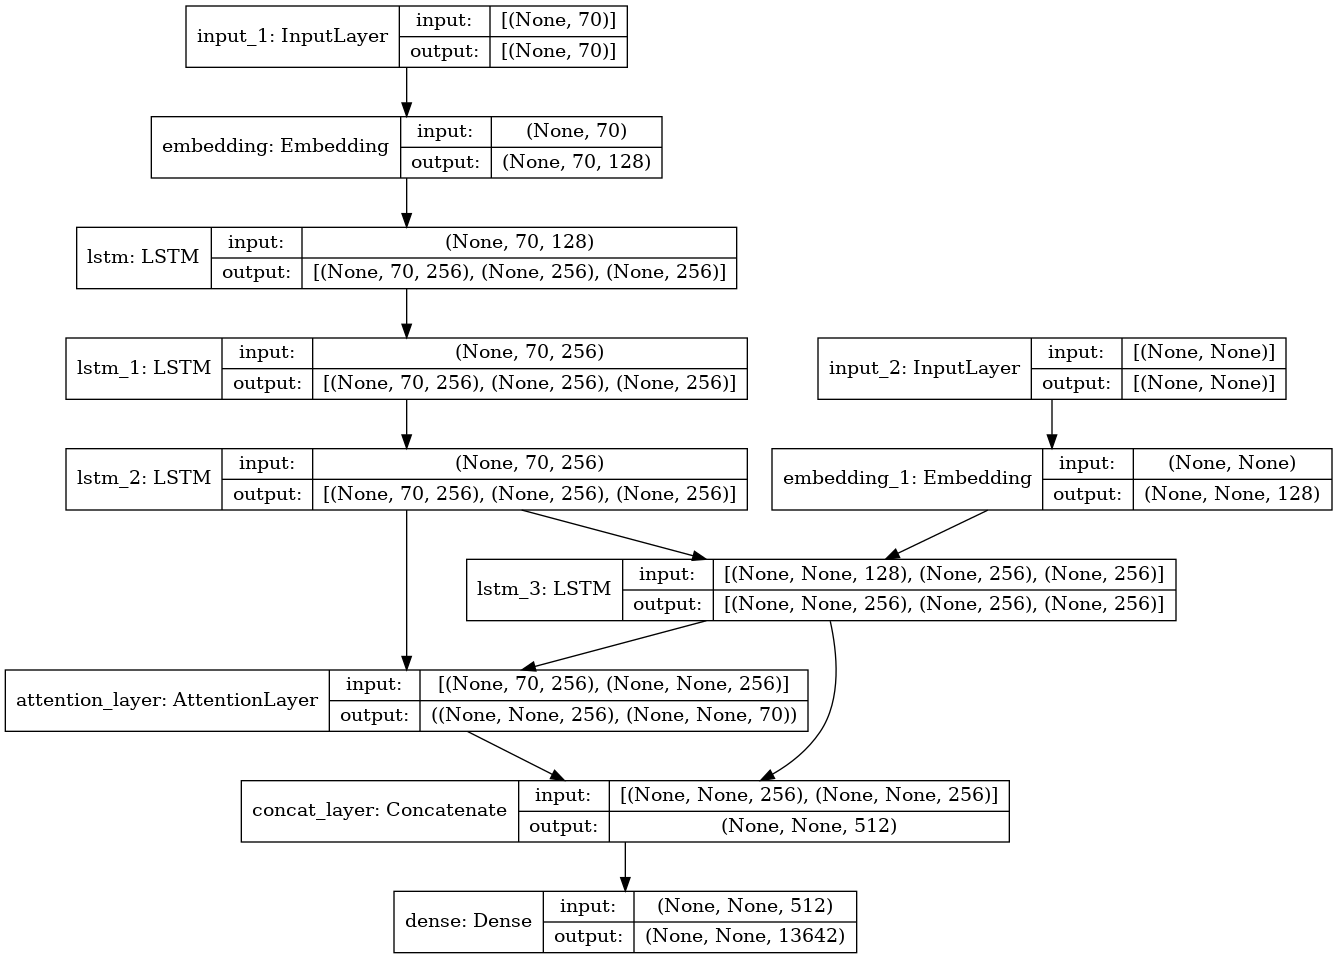

In [50]:
plot_model(model, show_shapes=True, show_layer_names=True)

## 모델 학습

In [51]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', experimental_run_tf_function=False)

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [53]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Train on 78663 samples, validate on 19666 samples
Epoch 1/50
78663/78663 [==============================] - 262s 3ms/sample - loss: 4.2931 - val_loss: 3.9490
Epoch 2/50
78663/78663 [==============================] - 255s 3ms/sample - loss: 3.8797 - val_loss: 3.7337
Epoch 3/50
78663/78663 [==============================] - 254s 3ms/sample - loss: 3.6828 - val_loss: 3.5671
Epoch 4/50
78663/78663 [==============================] - 254s 3ms/sample - loss: 3.4926 - val_loss: 3.3804
Epoch 5/50
78663/78663 [==============================] - 255s 3ms/sample - loss: 3.3146 - val_loss: 3.2404
Epoch 6/50
78663/78663 [==============================] - 254s 3ms/sample - loss: 3.1642 - val_loss: 3.1491
Epoch 7/50
78663/78663 [==============================] - 254s 3ms/sample - loss: 3.0408 - val_loss: 3.0523
Epoch 8/50
78663/78663 [==============================] - 252s 3ms/sample - loss: 2.9337 - val_loss: 2.9753
Epoch 9/50
78663/78663 [==============================] - 251s 3ms/sample - loss: 2.83

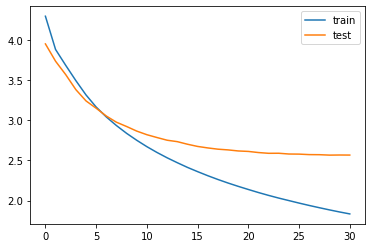

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [55]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [56]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [57]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<hr>

<br>


## 모델 검증, 성능 확인

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [60]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us based startup <OOV> which runs a platform to check spelling and <OOV> has raised million in funding from general catalyst <OOV> and spark capital this is the first venture round for the eight year old startup <OOV> has around lakh daily active users most of whom use the service for free 
실제 요약 : <OOV> spelling checking platform <OOV> raises mn 
예측 요약 :  us startup <OOV> raises million in series b funding


원문 : former india captain ms dhoni got angry at non striker manish pandey after the first ball of the last over of indias innings during the second t i against south africa on wednesday dhoni <OOV> asked pandey to focus towards him while he is batting instead of looking elsewhere the year old went on to smash the subsequent ball for a six 
실제 요약 : video dhoni gets angry at pandey for not paying attention 
예측 요약 :  dhoni bowls out of the last ball of the field in india


원문 : the operational head of jaish e mohammed khalid was killed in a gun battle with security forces in kas